In [286]:
import warnings
import pandas as pd
import numpy as np
import lightgbm as lgb
from matplotlib import pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.ar_model import AR
from sklearn.model_selection import KFold,train_test_split
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')
%matplotlib inline

# 数据导入

In [467]:
df1=pd.read_csv('area_passenger_index.csv',header=None
                ,names=['ID','time','people_index'])
df2=pd.read_csv('area_passenger_info.csv',header=None
                ,names=['ID','area_name','area_type','Center_x','Center_y','Grid_x','Grid_y','area'])
df3=pd.read_csv('migration_index.csv',header=None
            ,names=['date','departure_province','departure_city','arrival_province','arrival_city','index'])
df4=pd.read_csv('grid_strength_update.csv',header=None
                ,names=['hour','start_grid_x','start_grid_y','end_grid_x','end_grid_y','Index'])
sub=pd.read_csv('test_submit_example.csv',header=None
                ,names=['ID','time','people_index'])

# 处理df1

In [468]:
df1['time']=pd.to_datetime(df1['time'],format='%Y%m%d%H')
df1['day']=df1['time'].dt.day.apply(lambda x:x-17 if x>=17 else x+15)
df1['weekday']=df1['time'].dt.weekday
df1['hour']=df1['time'].dt.hour
df1.head()

,ID,time,people_index,day,weekday,hour
0,1,2020-01-17 00:00:00,1.8,0,4,0
1,1,2020-01-17 01:00:00,1.5,0,4,1
2,1,2020-01-17 02:00:00,1.3,0,4,2
3,1,2020-01-17 03:00:00,1.3,0,4,3
4,1,2020-01-17 04:00:00,1.7,0,4,4


In [469]:
dict_wd=dict(df1.groupby(['weekday']).mean()['people_index'])
dict_h=dict(df1.groupby(['hour']).mean()['people_index'])
dict_id=dict(df1.groupby(['ID']).mean()['people_index'])

In [470]:
df1['weekday_encoded']=df1['weekday'].map(dict_wd)
df1['hour_encoded']=df1['hour'].map(dict_h)
df1['ID_encoded']=df1['ID'].map(dict_id)

In [471]:
df1.head()

,ID,time,people_index,day,weekday,hour,weekday_encoded,hour_encoded,ID_encoded
0,1,2020-01-17 00:00:00,1.8,0,4,0,28.266556,12.499074,4.835556
1,1,2020-01-17 01:00:00,1.5,0,4,1,28.266556,8.617108,4.835556
2,1,2020-01-17 02:00:00,1.3,0,4,2,28.266556,7.245714,4.835556
3,1,2020-01-17 03:00:00,1.3,0,4,3,28.266556,6.373882,4.835556
4,1,2020-01-17 04:00:00,1.7,0,4,4,28.266556,6.205978,4.835556


In [472]:
train_data=df1.copy()

# 处理df2

In [473]:
train_data=pd.merge(df1,df2,on=['ID'])
train_data.head()

,ID,time,people_index,day,weekday,hour,weekday_encoded,hour_encoded,ID_encoded,area_name,area_type,Center_x,Center_y,Grid_x,Grid_y,area
0,1,2020-01-17 00:00:00,1.8,0,4,0,28.266556,12.499074,4.835556,北坞公园,旅游景点;公园,116.256586,39.986913,116.256713,39.987525,395925.609375
1,1,2020-01-17 01:00:00,1.5,0,4,1,28.266556,8.617108,4.835556,北坞公园,旅游景点;公园,116.256586,39.986913,116.256713,39.987525,395925.609375
2,1,2020-01-17 02:00:00,1.3,0,4,2,28.266556,7.245714,4.835556,北坞公园,旅游景点;公园,116.256586,39.986913,116.256713,39.987525,395925.609375
3,1,2020-01-17 03:00:00,1.3,0,4,3,28.266556,6.373882,4.835556,北坞公园,旅游景点;公园,116.256586,39.986913,116.256713,39.987525,395925.609375
4,1,2020-01-17 04:00:00,1.7,0,4,4,28.266556,6.205978,4.835556,北坞公园,旅游景点;公园,116.256586,39.986913,116.256713,39.987525,395925.609375


In [474]:
dict_at=dict(train_data.groupby(['area_type']).mean()['people_index'])

In [475]:
dict_at

{'交通设施;火车站': 97.90794444444481,
 '交通设施;长途汽车站': 17.410277777777786,
 '交通设施;飞机场': 1706.800694444446,
 '医疗;综合医院': 40.014151101532505,
 '教育培训;高等院校': 30.6513082437284,
 '旅游景点;公园': 10.071021072797901,
 '旅游景点;动物园': 26.88458333333331,
 '旅游景点;文物古迹': 8.648455687830781,
 '旅游景点;植物园': 13.579027777777775,
 '旅游景点;水族馆': 6.947152777777766,
 '旅游景点;游乐园': 11.726979166666549,
 '旅游景点;风景区': 32.58043447293434,
 '购物;购物中心': 41.63743173257953,
 '运动健身;体育场馆': 5.401324494949358}

In [476]:
train_data['area_type_encoded']=train_data['area_type'].map(dict_at)
train_data.head()

,ID,time,people_index,day,weekday,hour,weekday_encoded,hour_encoded,ID_encoded,area_name,area_type,Center_x,Center_y,Grid_x,Grid_y,area,area_type_encoded
0,1,2020-01-17 00:00:00,1.8,0,4,0,28.266556,12.499074,4.835556,北坞公园,旅游景点;公园,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021
1,1,2020-01-17 01:00:00,1.5,0,4,1,28.266556,8.617108,4.835556,北坞公园,旅游景点;公园,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021
2,1,2020-01-17 02:00:00,1.3,0,4,2,28.266556,7.245714,4.835556,北坞公园,旅游景点;公园,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021
3,1,2020-01-17 03:00:00,1.3,0,4,3,28.266556,6.373882,4.835556,北坞公园,旅游景点;公园,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021
4,1,2020-01-17 04:00:00,1.7,0,4,4,28.266556,6.205978,4.835556,北坞公园,旅游景点;公园,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021


In [477]:
train_data.drop(['area_name','area_type'],axis=1,inplace=True)
train_data.head()

,ID,time,people_index,day,weekday,hour,weekday_encoded,hour_encoded,ID_encoded,Center_x,Center_y,Grid_x,Grid_y,area,area_type_encoded
0,1,2020-01-17 00:00:00,1.8,0,4,0,28.266556,12.499074,4.835556,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021
1,1,2020-01-17 01:00:00,1.5,0,4,1,28.266556,8.617108,4.835556,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021
2,1,2020-01-17 02:00:00,1.3,0,4,2,28.266556,7.245714,4.835556,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021
3,1,2020-01-17 03:00:00,1.3,0,4,3,28.266556,6.373882,4.835556,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021
4,1,2020-01-17 04:00:00,1.7,0,4,4,28.266556,6.205978,4.835556,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021


# 处理df3

In [478]:
df3.head()

,date,departure_province,departure_city,arrival_province,arrival_city,index
0,20200117,陕西省,商洛市,北京市,北京市,0.00094
1,20200117,北京市,北京市,江西省,上饶市,0.01468
2,20200117,北京市,北京市,山东省,淄博市,0.03619
3,20200117,湖南省,怀化市,北京市,北京市,0.00288
4,20200117,山东省,淄博市,北京市,北京市,0.01698


In [479]:
df3['date']=pd.to_datetime(df3['date'],format='%Y%m%d')
df3['day_encode']=df3['date'].dt.day.apply(lambda x:x-17 if x>=17 else x+15)
index_mean=df3.groupby(['date']).mean()['index']
index_std=df3.groupby(['date']).std()['index']

In [480]:
index_mean_copy=index_mean.copy()
index_mean_copy.index=np.arange(30)
dict4=dict(index_mean_copy)

In [481]:
index_std_copy=index_std.copy()
index_std_copy.index=np.arange(30)
dict5=dict(index_std_copy)

In [482]:
train_data['index_mean']=train_data['day'].map(dict4)
train_data['index_std']=train_data['day'].map(dict5)

In [483]:
train_data.head()

,ID,time,people_index,day,weekday,hour,weekday_encoded,hour_encoded,ID_encoded,Center_x,Center_y,Grid_x,Grid_y,area,area_type_encoded,index_mean,index_std
0,1,2020-01-17 00:00:00,1.8,0,4,0,28.266556,12.499074,4.835556,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021,0.029868,0.104051
1,1,2020-01-17 01:00:00,1.5,0,4,1,28.266556,8.617108,4.835556,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021,0.029868,0.104051
2,1,2020-01-17 02:00:00,1.3,0,4,2,28.266556,7.245714,4.835556,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021,0.029868,0.104051
3,1,2020-01-17 03:00:00,1.3,0,4,3,28.266556,6.373882,4.835556,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021,0.029868,0.104051
4,1,2020-01-17 04:00:00,1.7,0,4,4,28.266556,6.205978,4.835556,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021,0.029868,0.104051


In [484]:
ar_model1=AR(index_mean.iloc[9:]).fit()
pred_index_mean=ar_model1.predict('20200216','20200224',dynamic=True)
pred_index_mean

2020-02-16    0.005028
2020-02-17    0.006440
2020-02-18    0.004973
2020-02-19    0.004377
2020-02-20    0.004534
2020-02-21    0.003751
2020-02-22    0.002961
2020-02-23    0.004020
2020-02-24    0.005636
Freq: D, dtype: float64

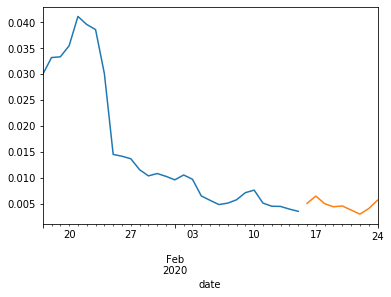

In [485]:
index_mean.plot()
pred_index_mean.plot()

In [486]:
ar_model2=AR(index_std.iloc[9:]).fit()
pred_index_std=ar_model2.predict('20200216','20200224',dynamic=True)
pred_index_std

2020-02-16    0.021989
2020-02-17    0.030587
2020-02-18    0.023958
2020-02-19    0.018747
2020-02-20    0.019755
2020-02-21    0.015803
2020-02-22    0.012030
2020-02-23    0.016810
2020-02-24    0.027461
Freq: D, dtype: float64

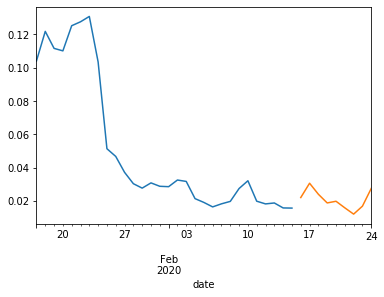

In [487]:
index_std.plot()
pred_index_std.plot()

# 处理df4

In [488]:
df4.head()

,hour,start_grid_x,start_grid_y,end_grid_x,end_grid_y,Index
0,0,115.994294,39.724830,115.994294,39.724830,0.2
1,0,115.994313,39.704025,115.994313,39.704025,0.1
2,0,115.994316,39.698475,115.994316,39.698475,0.2
3,0,115.994316,39.683207,115.994316,39.683207,0.1
4,0,115.994316,39.697087,115.994316,39.697087,0.1


In [489]:
dict_hi=dict(df4.groupby(['hour']).mean()['Index'])

In [490]:
train_data['hi_encoded']=train_data['hour'].map(dict_hi)

In [491]:
train_data.head()

,ID,time,people_index,day,weekday,hour,weekday_encoded,hour_encoded,ID_encoded,Center_x,Center_y,Grid_x,Grid_y,area,area_type_encoded,index_mean,index_std,hi_encoded
0,1,2020-01-17 00:00:00,1.8,0,4,0,28.266556,12.499074,4.835556,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021,0.029868,0.104051,0.218439
1,1,2020-01-17 01:00:00,1.5,0,4,1,28.266556,8.617108,4.835556,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021,0.029868,0.104051,0.219937
2,1,2020-01-17 02:00:00,1.3,0,4,2,28.266556,7.245714,4.835556,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021,0.029868,0.104051,0.202704
3,1,2020-01-17 03:00:00,1.3,0,4,3,28.266556,6.373882,4.835556,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021,0.029868,0.104051,0.194659
4,1,2020-01-17 04:00:00,1.7,0,4,4,28.266556,6.205978,4.835556,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021,0.029868,0.104051,0.264326


In [492]:
train_data

,ID,time,people_index,day,weekday,hour,weekday_encoded,hour_encoded,ID_encoded,Center_x,Center_y,Grid_x,Grid_y,area,area_type_encoded,index_mean,index_std,hi_encoded
0,1,2020-01-17 00:00:00,1.8,0,4,0,28.266556,12.499074,4.835556,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021,0.029868,0.104051,0.218439
1,1,2020-01-17 01:00:00,1.5,0,4,1,28.266556,8.617108,4.835556,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021,0.029868,0.104051,0.219937
2,1,2020-01-17 02:00:00,1.3,0,4,2,28.266556,7.245714,4.835556,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021,0.029868,0.104051,0.202704
3,1,2020-01-17 03:00:00,1.3,0,4,3,28.266556,6.373882,4.835556,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021,0.029868,0.104051,0.194659
4,1,2020-01-17 04:00:00,1.7,0,4,4,28.266556,6.205978,4.835556,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021,0.029868,0.104051,0.264326
5,1,2020-01-17 05:00:00,1.2,0,4,5,28.266556,7.780906,4.835556,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021,0.029868,0.104051,0.363245
6,1,2020-01-17 06:00:00,2.9,0,4,6,28.266556,13.849278,4.835556,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021,0.029868,0.104051,0.756316
7,1,2020-01-17 07:00:00,4.7,0,4,7,28.266556,22.833651,4.835556,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021,0.029868,0.104051,1.387582
8,1,2020-01-17 08:00:00,6.1,0,4,8,28.266556,31.165440,4.835556,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021,0.029868,0.104051,1.385265
9,1,2020-01-17 09:00:00,5.2,0,4,9,28.266556,35.761210,4.835556,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021,0.029868,0.104051,1.095209


# 测试数据

In [493]:
test_data=sub.copy()
test_data.head()

,ID,time,people_index
0,1,2020021600,1.5
1,1,2020021601,1.5
2,1,2020021602,1.5
3,1,2020021603,1.5
4,1,2020021604,1.5


In [494]:
test_data.drop(['people_index'],axis=1,inplace=True)
test_data['time']=pd.to_datetime(df11['time'],format='%Y%m%d%H')
test_data['weekday']=test_data['time'].dt.weekday
test_data['hour']=test_data['time'].dt.hour
test_data['weekday_encoded']=test_data['weekday'].map(dict_wd)
test_data['hour_encoded']=test_data['hour'].map(dict_h)
test_data['ID_encoded']=test_data['ID'].map(dict_id)
test_data['day']=test_data['time'].dt.day.apply(lambda x:x+15)
test_data.head()

,ID,time,weekday,hour,weekday_encoded,hour_encoded,ID_encoded,day
0,1,2020-02-16 00:00:00,6,0,27.552537,12.499074,4.835556,31
1,1,2020-02-16 01:00:00,6,1,27.552537,8.617108,4.835556,31
2,1,2020-02-16 02:00:00,6,2,27.552537,7.245714,4.835556,31
3,1,2020-02-16 03:00:00,6,3,27.552537,6.373882,4.835556,31
4,1,2020-02-16 04:00:00,6,4,27.552537,6.205978,4.835556,31


In [495]:
pred_index_mean.index=np.arange(31,40,1)
dict_pim=dict(pred_index_mean)
pred_index_std.index=np.arange(31,40,1)
dict_pis=dict(pred_index_std)

In [496]:
test_data['index_mean']=test_data['day'].map(dict_pim)
test_data['index_std']=test_data['day'].map(dict_pis)

In [497]:
test_data.head()

,ID,time,weekday,hour,weekday_encoded,hour_encoded,ID_encoded,day,index_mean,index_std
0,1,2020-02-16 00:00:00,6,0,27.552537,12.499074,4.835556,31,0.005028,0.021989
1,1,2020-02-16 01:00:00,6,1,27.552537,8.617108,4.835556,31,0.005028,0.021989
2,1,2020-02-16 02:00:00,6,2,27.552537,7.245714,4.835556,31,0.005028,0.021989
3,1,2020-02-16 03:00:00,6,3,27.552537,6.373882,4.835556,31,0.005028,0.021989
4,1,2020-02-16 04:00:00,6,4,27.552537,6.205978,4.835556,31,0.005028,0.021989


In [498]:
test_data=pd.merge(test_data,df2,on=['ID'])
test_data.head()

,ID,time,weekday,hour,weekday_encoded,hour_encoded,ID_encoded,day,index_mean,index_std,area_name,area_type,Center_x,Center_y,Grid_x,Grid_y,area
0,1,2020-02-16 00:00:00,6,0,27.552537,12.499074,4.835556,31,0.005028,0.021989,北坞公园,旅游景点;公园,116.256586,39.986913,116.256713,39.987525,395925.609375
1,1,2020-02-16 01:00:00,6,1,27.552537,8.617108,4.835556,31,0.005028,0.021989,北坞公园,旅游景点;公园,116.256586,39.986913,116.256713,39.987525,395925.609375
2,1,2020-02-16 02:00:00,6,2,27.552537,7.245714,4.835556,31,0.005028,0.021989,北坞公园,旅游景点;公园,116.256586,39.986913,116.256713,39.987525,395925.609375
3,1,2020-02-16 03:00:00,6,3,27.552537,6.373882,4.835556,31,0.005028,0.021989,北坞公园,旅游景点;公园,116.256586,39.986913,116.256713,39.987525,395925.609375
4,1,2020-02-16 04:00:00,6,4,27.552537,6.205978,4.835556,31,0.005028,0.021989,北坞公园,旅游景点;公园,116.256586,39.986913,116.256713,39.987525,395925.609375


In [499]:
test_data.drop(['Center_x','Center_y','Grid_x','Grid_y'],axis=1,inplace=True)
test_data.head()

,ID,time,weekday,hour,weekday_encoded,hour_encoded,ID_encoded,day,index_mean,index_std,area_name,area_type,area
0,1,2020-02-16 00:00:00,6,0,27.552537,12.499074,4.835556,31,0.005028,0.021989,北坞公园,旅游景点;公园,395925.609375
1,1,2020-02-16 01:00:00,6,1,27.552537,8.617108,4.835556,31,0.005028,0.021989,北坞公园,旅游景点;公园,395925.609375
2,1,2020-02-16 02:00:00,6,2,27.552537,7.245714,4.835556,31,0.005028,0.021989,北坞公园,旅游景点;公园,395925.609375
3,1,2020-02-16 03:00:00,6,3,27.552537,6.373882,4.835556,31,0.005028,0.021989,北坞公园,旅游景点;公园,395925.609375
4,1,2020-02-16 04:00:00,6,4,27.552537,6.205978,4.835556,31,0.005028,0.021989,北坞公园,旅游景点;公园,395925.609375


In [500]:
test_data['hi_encoded']=test_data['hour'].map(dict_hi)

In [501]:
test_data['area_type_encoded']=test_data['area_type'].map(dict_at)

In [502]:
test_data.drop(['ID','time','weekday','hour','day','area_name','area_type'],axis=1,inplace=True)

In [503]:
test_data.head()

,weekday_encoded,hour_encoded,ID_encoded,index_mean,index_std,area,hi_encoded,area_type_encoded
0,27.552537,12.499074,4.835556,0.005028,0.021989,395925.609375,0.218439,10.071021
1,27.552537,8.617108,4.835556,0.005028,0.021989,395925.609375,0.219937,10.071021
2,27.552537,7.245714,4.835556,0.005028,0.021989,395925.609375,0.202704,10.071021
3,27.552537,6.373882,4.835556,0.005028,0.021989,395925.609375,0.194659,10.071021
4,27.552537,6.205978,4.835556,0.005028,0.021989,395925.609375,0.264326,10.071021


# 模型

In [504]:
train_data=train_data[train_data['day']>=18]
train_data.shape

(311064, 18)

In [505]:
train_data.index=np.arange(311064)

In [506]:
target=train_data['people_index']

In [507]:
train_data.head()

,ID,time,people_index,day,weekday,hour,weekday_encoded,hour_encoded,ID_encoded,Center_x,Center_y,Grid_x,Grid_y,area,area_type_encoded,index_mean,index_std,hi_encoded
0,1,2020-02-03 00:00:00,1.6,18,0,0,28.212716,12.499074,4.835556,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021,0.006464,0.021335,0.218439
1,1,2020-02-03 01:00:00,0.7,18,0,1,28.212716,8.617108,4.835556,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021,0.006464,0.021335,0.219937
2,1,2020-02-03 02:00:00,0.9,18,0,2,28.212716,7.245714,4.835556,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021,0.006464,0.021335,0.202704
3,1,2020-02-03 03:00:00,1.0,18,0,3,28.212716,6.373882,4.835556,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021,0.006464,0.021335,0.194659
4,1,2020-02-03 04:00:00,0.7,18,0,4,28.212716,6.205978,4.835556,116.256586,39.986913,116.256713,39.987525,395925.609375,10.071021,0.006464,0.021335,0.264326


In [508]:
train_data.drop(['people_index','day','ID','weekday','hour','Center_x','Center_y','Grid_x','Grid_y','time']
                ,axis=1,inplace=True)
train_data.head()

,weekday_encoded,hour_encoded,ID_encoded,area,area_type_encoded,index_mean,index_std,hi_encoded
0,28.212716,12.499074,4.835556,395925.609375,10.071021,0.006464,0.021335,0.218439
1,28.212716,8.617108,4.835556,395925.609375,10.071021,0.006464,0.021335,0.219937
2,28.212716,7.245714,4.835556,395925.609375,10.071021,0.006464,0.021335,0.202704
3,28.212716,6.373882,4.835556,395925.609375,10.071021,0.006464,0.021335,0.194659
4,28.212716,6.205978,4.835556,395925.609375,10.071021,0.006464,0.021335,0.264326


In [510]:
test_new=pd.DataFrame([test_data['weekday_encoded']
                     ,test_data['hour_encoded']
                     ,test_data['ID_encoded']
                     ,test_data['area']
                     ,test_data['area_type_encoded']
                     ,test_data['index_mean']
                     ,test_data['index_std']
                     ,test_data['hi_encoded']]).T
test_new.head()

,weekday_encoded,hour_encoded,ID_encoded,area,area_type_encoded,index_mean,index_std,hi_encoded
0,27.552537,12.499074,4.835556,395925.609375,10.071021,0.005028,0.021989,0.218439
1,27.552537,8.617108,4.835556,395925.609375,10.071021,0.005028,0.021989,0.219937
2,27.552537,7.245714,4.835556,395925.609375,10.071021,0.005028,0.021989,0.202704
3,27.552537,6.373882,4.835556,395925.609375,10.071021,0.005028,0.021989,0.194659
4,27.552537,6.205978,4.835556,395925.609375,10.071021,0.005028,0.021989,0.264326


In [511]:
model_lgb=lgb.LGBMRegressor(num_leaves=20
                            ,max_depth=6
                            ,learning_rate=0.11
                            ,n_estimators=800
                            ,n_jobs=-1)

In [512]:
x_train,x_test,y_train,y_test=train_test_split(train_data,target,test_size=0.3,random_state=5050)
model_lgb.fit(x_train,y_train)
y_hat=model_lgb.predict(x_test)
y_hat[y_hat<0]=0
print(1/(mean_squared_error(y_test,y_hat)**0.5+1))

0.20132754427294217


In [513]:
keys=[]

sk=KFold(n_splits=10,shuffle=True,random_state=5527845)
for train,test in sk.split(train_data,target):
    
    x_train=train_data.iloc[train]
    y_train=target.iloc[train]
    x_test=train_data.iloc[test]
    y_test=target.iloc[test]
    
    model_lgb.fit(x_train,y_train)
    y_hat=model_lgb.predict(x_test)
    y_hat[y_hat<0]=0
    print(1/(mean_squared_error(y_test,y_hat)**0.5+1))
    keys.append(model_lgb.predict(test_new))

0.2023172063375465
0.20704454118099863
0.2059438538368398
0.2112245701112364
0.20089008230701677
0.21327127253020953
0.2075369720779041
0.21219450874065765
0.19393977240835275
0.1745913652537372


# 生成答案

In [514]:
keys=np.array(keys)
keys

array([[2.28332117, 1.38054722, 1.02141157, ..., 0.06935015, 0.12423535,
        0.01327648],
       [2.32613684, 1.33137522, 1.13753692, ..., 0.02683747, 0.17740382,
        0.0554042 ],
       [2.3222253 , 1.37262607, 1.07228506, ..., 0.08668861, 0.09265623,
        0.03971097],
       ...,
       [2.58168252, 1.69535143, 1.41968979, ..., 0.16159112, 0.22481946,
        0.11618402],
       [2.18134904, 1.34305348, 1.15445458, ..., 0.14560869, 0.20833133,
        0.174488  ],
       [2.46719408, 1.34584487, 0.96620881, ..., 0.20080546, 0.27038564,
        0.15777824]])

In [515]:
keys.shape

(10, 215352)

In [516]:
km=keys.mean(axis=0)

In [517]:
km[km<0]=0
km

array([2.37534057, 1.44450875, 1.14190589, ..., 0.1094497 , 0.16044801,
       0.08652636])

In [518]:
sub.iloc[:,2]=km

In [519]:
sub.to_csv('block_predict_result.csv',encoding='utf-8',header=None,index=None)

In [520]:
sub.tail(24)

,ID,time,people_index
215328,997,2020022400,0.026370
215329,997,2020022401,0.000000
215330,997,2020022402,0.070964
215331,997,2020022403,0.024623
215332,997,2020022404,0.000000
215333,997,2020022405,0.000000
215334,997,2020022406,0.006984
215335,997,2020022407,0.136567
215336,997,2020022408,0.304994
215337,997,2020022409,0.270730
